<a href="https://colab.research.google.com/github/NabilaPutriNurhaliza/Streamlit_GAN/blob/master/modelGAN_SIB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import Input, Dropout, Concatenate, Dense, LeakyReLU, Flatten
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model
import gdown
import zipfile

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
devices= tf.config.experimental.list_physical_devices("GPU")
for device in devices:
  tf.config.experimental.set_memory_growth(device=device, enable=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Download the dataset from Google Drive link
file_id = '1s1Y5i1MSSjMCLESRJ7wXRit5iSSTVrys'
gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', 'dataset.zip', quiet=False)

# Unzip the dataset
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Define the paths for training data
data_dir = '/content/dataset'

Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1s1Y5i1MSSjMCLESRJ7wXRit5iSSTVrys
From (redirected): https://drive.google.com/uc?export=download&id=1s1Y5i1MSSjMCLESRJ7wXRit5iSSTVrys&confirm=t&uuid=d3100e32-901e-48ed-af6c-0522ec623a23
To: /content/dataset.zip
100%|██████████| 37.3M/37.3M [00:01<00:00, 28.2MB/s]


In [ ]:
image_path = "/content/dataset/cartoon"
images = [os.path.join(image_path, i) for i in os.listdir(image_path)]
images[:2]

['/content/dataset/cartoon/Cartoons_00159_02.jpg',
 '/content/dataset/cartoon/Cartoons_00145_04.jpg']

In [ ]:
MODEL_NAME = 'WGAN'
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", "WGAN", 'train_data') # Sets up a log directory.
TARGET_IMG_SIZE = 64 # Scale images to this size
BATCH_SIZE = 128
NOISE_DIM = 100
LAMBDA = 10 # For gradient penalty

EPOCHs = 80
CURRENT_EPOCH = 1 # Epoch start from
SAVE_EVERY_N_EPOCH = 15 # Save checkpoint at every n epoch

N_CRITIC = 3 # Train critic(discriminator) n times then train generator 1 time.
LR = 1e-4
MIN_LR = 0.000001 # Minimum value of learning rate
DECAY_FACTOR=1.00004 # learning rate decay factor

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

In [ ]:
list_ds = tf.data.Dataset.list_files('/content/dataset/cartoon/*')

for f in list_ds.take(5):
    print(f.numpy())

b'/content/dataset/cartoon/Cartoons_00383_06.jpg'
b'/content/dataset/cartoon/Cartoons_00356_02.jpg'
b'/content/dataset/cartoon/Cartoons_00073_01.jpg'
b'/content/dataset/cartoon/Cartoons_00170_01.jpg'
b'/content/dataset/cartoon/Cartoons_00174_01.jpg'


In [ ]:
def normalize(image):
    '''
        normalizing the images to [-1, 1]
    '''
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

In [ ]:
def preprocess_image(file_path):
    images = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, (TARGET_IMG_SIZE, TARGET_IMG_SIZE),
                           method='bicubic', antialias=True)
    images = normalize(images)
    return images

In [ ]:
train_data = list_ds.map(preprocess_image).shuffle(1000).batch(BATCH_SIZE)

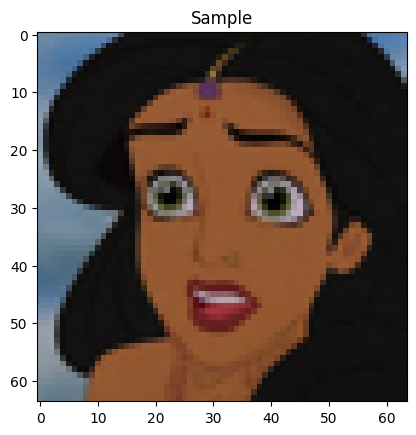

In [ ]:
sample_img = next(iter(train_data))
plt.title('Sample')
plt.imshow(np.clip(sample_img[0] * 0.5 + 0.5, 0, 1))

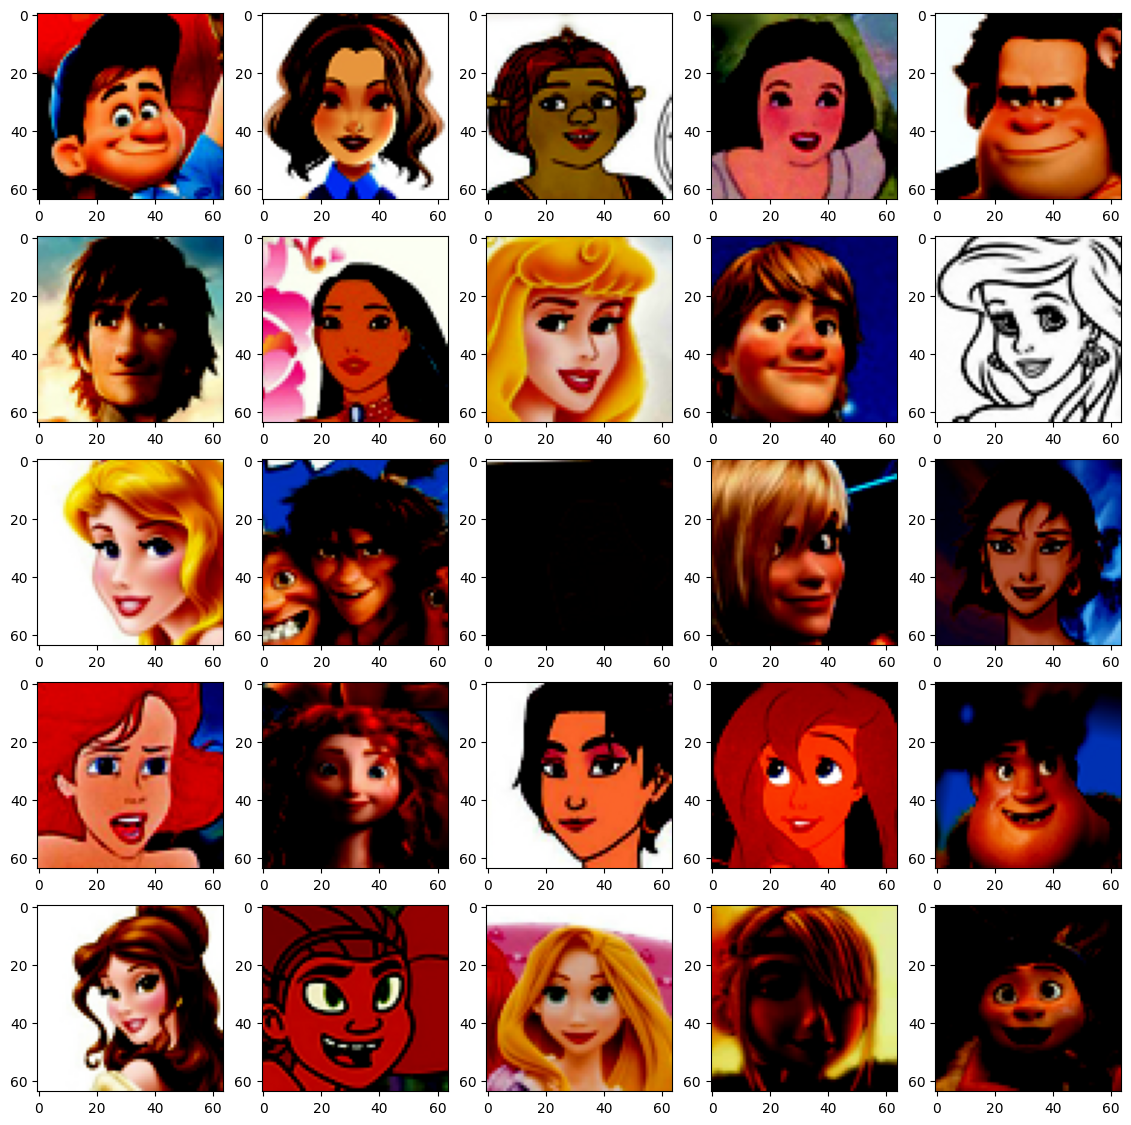

In [ ]:
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = train_data.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
  for column in range(5):
    axes[row, column].imshow(sample[idx])
    idx+=1

In [ ]:
def CGAN_generator(input_z_shape=NOISE_DIM):
    '''
        DCGAN like generator architecture
    '''
    input_z_layer = Input(input_z_shape)

    z = Dense(4*4*512, use_bias=False)(input_z_layer)
    z =Reshape((4, 4, 512))(z)

    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)

    model = Model(inputs=input_z_layer, outputs=output)
    return model

In [ ]:
def CGAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)):
    '''
        DCGAN like discriminator architecture
    '''
    input_x_layer = Input(input_x_shape)

    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)

    x = Flatten()(x)

    output = Dense(1)(x)

    model = Model(inputs=input_x_layer, outputs=output)
    return model

In [ ]:
generator = CGAN_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 8192)              819200    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         4194304   
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 4, 512)         0     

In [ ]:
discriminator = CGAN_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524288    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 256)         0   

In [ ]:
D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

In [ ]:
def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    '''
        Calculate new learning rate using decay factor
    '''
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

In [ ]:
def set_learning_rate(new_lr):
    '''
        Set new learning rate to optimizers
    '''
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)

In [ ]:
checkpoint_path = os.path.join("checkpoints", "tensorflow", MODEL_NAME)

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

In [ ]:
def generate_and_save_images(model, epoch, test_input, figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False):
    '''
        Generate images and plot it.
    '''
    predictions = model.predict(test_input)
    if is_flatten:
        predictions = predictions.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3).astype('float32')
    fig = plt.figure(figsize=figure_size)
    for i in range(predictions.shape[0]):
        axs = plt.subplot(subplot[0], subplot[1], i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)
        plt.axis('off')
    if save:
        plt.savefig(os.path.join("output", 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

1/1 [==============================] - 1s 594ms/step


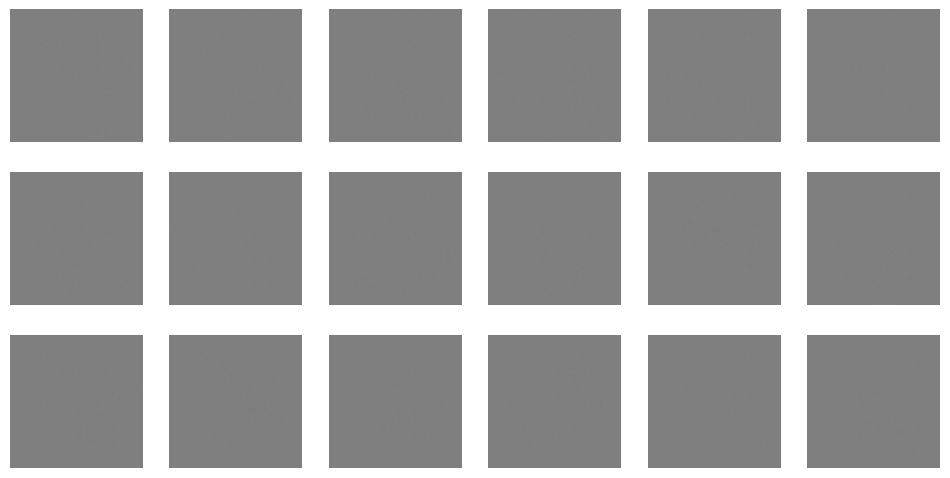

In [ ]:
num_examples_to_generate = 18

# We will reuse this seed overtime
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
generate_and_save_images(generator, 0, [sample_noise], figure_size=(12,6), subplot=(3,6), save=False, is_flatten=False)

In [ ]:
# Initialize lists to store losses
D_losses = []
G_losses = []

In [ ]:
@tf.function
def WGAN_GP_train_d_step(real_image, batch_size, step):
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            fake_image = generator([noise], training=True)
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)

        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))

        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)

        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
        # Calculate the gradients for discriminator
        D_gradients = d_tape.gradient(D_loss,
                                      discriminator.trainable_variables)
        # Apply the gradients to the optimizer
        D_optimizer.apply_gradients(zip(D_gradients,
                                        discriminator.trainable_variables))
        # Write loss values to tensorboard
        if step % 10 == 0:
            with file_writer.as_default():
                tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)
    return D_loss

In [ ]:
@tf.function
def WGAN_GP_train_g_step(real_image, batch_size, step):
    noise = tf.random.normal([batch_size, NOISE_DIM])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        fake_image = generator([noise], training=True)
        fake_pred = discriminator([fake_image], training=True)
        G_loss = -tf.reduce_mean(fake_pred)

        # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)
    return G_loss


In [ ]:
current_learning_rate = LR
trace = True
n_critic_count = 0

1/1 [==============================] - 0s 286ms/step


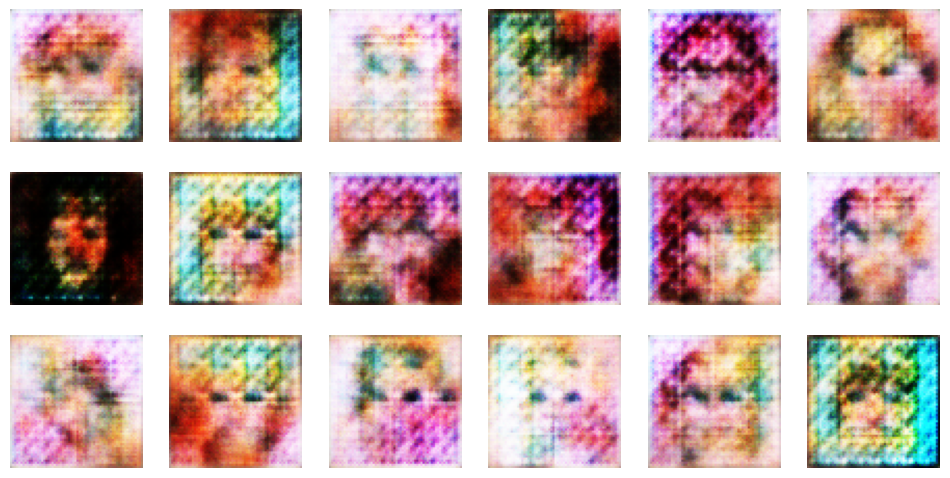

Time taken for epoch 80 is 34.544374227523804 sec



In [ ]:
if not os.path.exists("output"):
  os.mkdir("output")

for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
  start = time.time()
  print('Start of epoch %d' % (epoch,))

  # Using Learning rate decay
  current_learning_rate = learning_rate_decay(current_learning_rate)
  print('current_learning_rate %f' % (current_learning_rate,))
  set_learning_rate(current_learning_rate)

  # Inisialisasi list untuk menyimpan nilai loss per epoch
  epoch_D_losses = []
  epoch_G_losses = []

  for step, (image) in enumerate(train_data):
    current_batch_size = image.shape[0]
    # Train critic (discriminator)
    D_loss = WGAN_GP_train_d_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
    n_critic_count += 1
    if n_critic_count >= N_CRITIC:
        G_loss = WGAN_GP_train_g_step(image, batch_size= tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        n_critic_count = 0
        epoch_G_losses.append(G_loss)
    epoch_D_losses.append(D_loss)

    if step % 10 == 0:
        print ('.', end='')

  D_losses.append(tf.reduce_mean(epoch_D_losses))
  G_losses.append(tf.reduce_mean(epoch_G_losses))

  # Clear jupyter notebook cell output
  clear_output(wait=True)
  # Using a consistent sample so that the progress of the model is clearly visible.
  generate_and_save_images(generator, epoch, [sample_noise], figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False)

  if epoch % SAVE_EVERY_N_EPOCH == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))


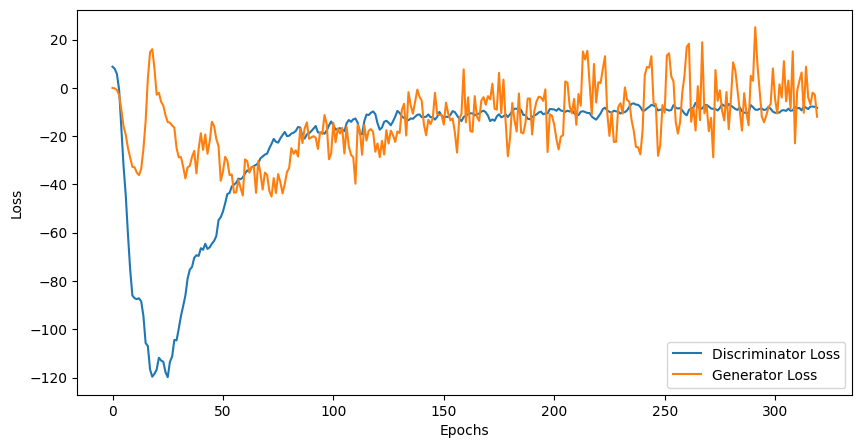

In [ ]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(D_losses, label="Discriminator Loss")
plt.plot(G_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Saving Cartoons_00540_01.jpg to Cartoons_00540_01.jpg
1/1 [==============================] - 0s 54ms/step


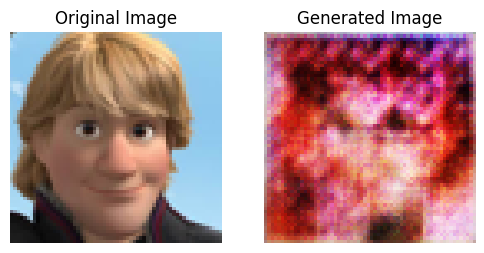

In [ ]:
from google.colab import files
import io
from PIL import Image

def upload_and_generate_images(generator, target_img_size=64, num_examples_to_generate=1):
    """
    Upload images and generate new images using the trained generator
    """
    uploaded = files.upload()
    for filename in uploaded.keys():
        image = Image.open(io.BytesIO(uploaded[filename])).resize((target_img_size, target_img_size))
        image = np.array(image) / 127.5 - 1.0  # Normalize to [-1, 1]

        plt.figure(figsize=(6, 6))
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow((image + 1.0) * 0.5)
        plt.axis('off')

        noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
        generated_image = generator.predict(noise)[0]

        plt.subplot(1, 2, 2)
        plt.title('Generated Image')
        plt.imshow((generated_image + 1.0) * 0.5)
        plt.axis('off')
        plt.show()

# Contoh penggunaan:
upload_and_generate_images(generator)


In [ ]:
generator.save("generator_model.h5")